In [1]:
import boto3
import awswrangler as wr
import pandas as pd
from tqdm import tqdm
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

In [2]:
data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]
sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)
df_dict = {}
for source in data_sources:
	dfs = []
	print(source)
	for path in tqdm(sources_dict[source]):
		new_df = wr.s3.read_parquet(path, boto3_session=session)
		new_df["date"] = path.split("/")[-1].split(".")[0]
		dfs.append(new_df)

	df_dict[source] = pd.concat(dfs, axis = 0)
joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
joined_df.shape

seekingAlpha.seekingAlphaBulkMetrics


  0%|          | 0/8 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_16484/716229386.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 12%|█▎        | 1/8 [00:00<00:04,  1.56it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_16484/716229386.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 25%|██▌       | 2/8 [00:01<00:04,  1.36it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ip

gurufocus


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


(12708, 337)

In [4]:
all_dates = joined_df.index.get_level_values(0).unique().sort_values().values
all_dates[:5]

array(['2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03',
       '2023-10-04'], dtype=object)

In [5]:
joined_df.loc["2023-09-28"]

,altman_z_score,analysts_down,analysts_down_percent,analysts_down_percent_avg_5y,analysts_up,analysts_up_percent,analysts_up_percent_avg_5y,assets_turnover,assets_turnover_avg_5y,authors_count,...,area,Price-to-DCF__Earnings_Based_,Price-to-DCF__FCF_Based_,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-FFO,Volume,Avg_Volume__2M_,Market_Cap,Enterprise_Value
ticker,,,,,,,,,,,,,,,,,,,,,
A,6.153144,15.0,100.000000,12.759212,0.0,0.000000,87.240790,0.661089,0.601508,4.0,...,Medical Diagnostics & Research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,1.401235,7.0,100.000000,60.404625,0.0,0.000000,39.595375,0.728491,0.757975,2.0,...,Metals & Mining,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,0.862385,9.0,52.941177,53.991806,8.0,47.058823,46.008194,0.782322,0.599356,7.0,...,Transportation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAP,2.266178,15.0,100.000000,39.274876,0.0,0.000000,60.725124,0.917976,0.929945,8.0,...,Retail - Cyclical,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,7.639575,8.0,22.222221,23.935060,28.0,77.777780,76.064940,1.143769,0.929182,36.0,...,Hardware,1.29,1.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZS,4.317831,4.0,12.121212,16.110676,29.0,87.878784,83.889320,0.502082,0.491221,10.0,...,Software,NaN,NaN,3018.4,NaN,NaN,NaN,NaN,NaN,NaN
ZTO,4.868613,2.0,18.181818,50.492565,9.0,81.818184,49.507435,0.498667,0.510452,1.0,...,Transportation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTS,7.658604,1.0,9.090909,28.892622,10.0,90.909090,71.107376,0.597550,0.566861,3.0,...,Drug Manufacturers,1.17,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
overlap_tickers = set(joined_df.index.get_level_values(1).tolist())

for d in tqdm(all_dates):
	day_df = joined_df.loc[d]
	overlap_tickers = overlap_tickers.intersection(set(day_df.index.tolist()))
	print(len(overlap_tickers))

len(overlap_tickers)

100%|██████████| 8/8 [00:00<00:00, 2256.82it/s]

1570
1553
1543
1538
1531
1529
1523
1518


1518

In [9]:
filtered_df = joined_df[joined_df.index.get_level_values(1).isin(overlap_tickers)]
filtered_df.shape

(12144, 337)

In [23]:
day_df_0 = filtered_df.loc["2023-10-02"].select_dtypes(float)

In [25]:
corr_cols = []

for d in all_dates[2:]:
	day_df = filtered_df.loc[d].select_dtypes(float)
	cols = day_df_0.corrwith(day_df)
	corr_cols.append(cols)

Text(0, 0.5, 'Pearson')

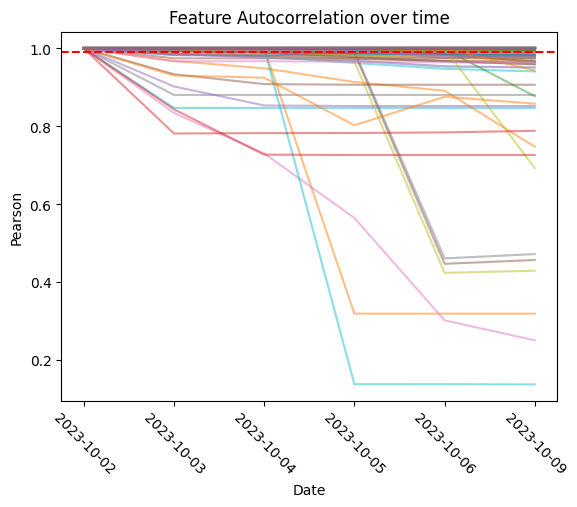

In [36]:
import matplotlib.pyplot as plt
corr_df = pd.DataFrame(corr_cols)
corr_df.plot(legend=None, alpha = 0.5)
plt.axhline(y = .99, color = "r", linestyle = "dashed")
plt.title("Feature Autocorrelation over time")
plt.xticks(ticks = [i for i in range(len(all_dates[2:]))], labels = all_dates[2:], rotation = -45)
plt.xlabel("Date")
plt.ylabel("Pearson")

In [28]:
long_term_columns = corr_df.columns[(corr_df.min() > 0.99)]
short_term_columns = corr_df.columns[(corr_df.min() <= 0.99)]

In [29]:
len(short_term_columns)

43

In [34]:
corr_df.min().sort_values().head(50)

pb_ratio                                                         0.137779
last_price_vs_sma_10d                                            0.251145
debt_eq                                                          0.319426
last_price_vs_sma_50d                                            0.424203
last_price_vs_sma_100d                                           0.447343
last_price_vs_sma_200d                                           0.461280
return_on_total_capital                                          0.693022
5-Day_RSI                                                        0.726598
dps_consensus_mean_percent_revisions_down_1_annual_period_fwd    0.747933
Forward_PE_Ratio                                                 0.781753
Volume                                                           0.802927
coefficient_of_variation_90d                                     0.847355
9-Day_RSI                                                        0.852247
moment_rank                           

In [33]:
corr_df.min().sort_values().loc["Volume"]

0.802927418062821

In [37]:
joined_df.shape

(12708, 337)